# Fraudulent Job Postings

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud


# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


#Data Evaluation 
from imblearn.over_sampling import SMOTE

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')


## Data Understanding

In [2]:
df = pd.read_csv('../Data/fake_job_postings.csv', index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.shape

(17880, 17)

<AxesSubplot:>

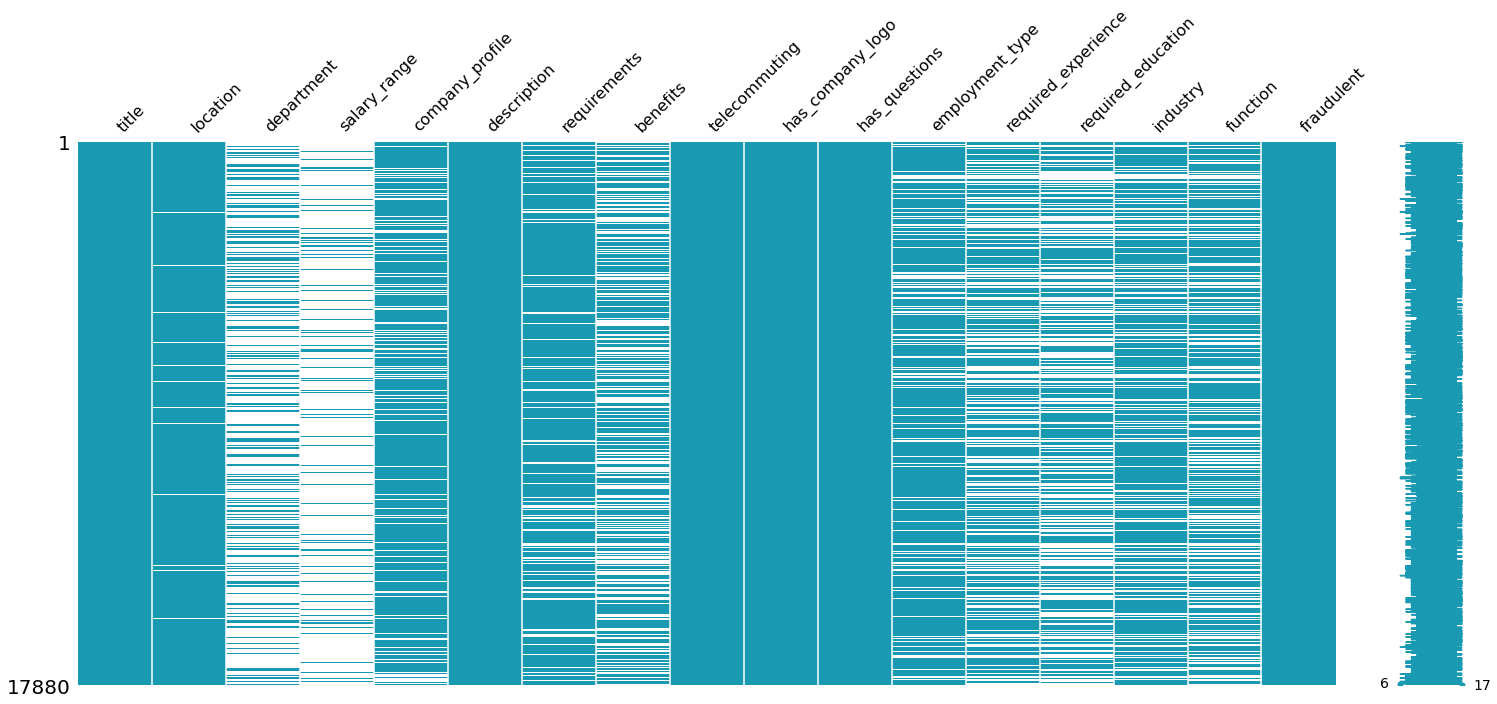

In [6]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- oh wow lots of missing values

### Target
- Fraudulent

In [8]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

## Data Prep

In [28]:
df.location

job_id
1            US, NY, New York
2              NZ, , Auckland
3               US, IA, Wever
4          US, DC, Washington
5          US, FL, Fort Worth
                 ...         
17876         CA, ON, Toronto
17877    US, PA, Philadelphia
17878         US, TX, Houston
17879           NG, LA, Lagos
17880       NZ, N, Wellington
Name: location, Length: 17880, dtype: object

In [29]:
def split(location):
    contries = location.split(" , ")
    print(contries)
    return contries[0]


In [30]:
# df['country'] = df.location.apply(split)

- Oh well, prob not even important 

### Dealing with missing values from requirements and benefits

In [31]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [32]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('no description listed')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('no required_experience listed')


In [36]:
df.description.isna().sum()

0

In [37]:
df.loc[17514]

title                                 Office Manager
location                              PL, MZ, Warsaw
department                                       NaN
salary_range                                     NaN
company_profile                                  NaN
description                    no description listed
requirements                   no requirement listed
benefits                           no benefit listed
telecommuting                                      0
has_company_logo                                   0
has_questions                                      0
employment_type                                  NaN
required_experience    no required_experience listed
required_education                               NaN
industry                                         NaN
function                                         NaN
fraudulent                                         1
has_benefit                                    False
has_requirements                              

 ### Combining our text data in a single column to start the cleaning  process

In [38]:
# 
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ df['benefits']+'  '+ df['required_experience']
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,no benefit listed,0,1,0,NaN,no required_experience listed,NaN,NaN,NaN,0,False,True,Commissioning Machinery Assistant (CMA) Our...
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,True,True,Account Executive - Washington DC THE COMPA...
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,True,True,Bill Review Manager JOB TITLE: Itemization ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,True,True,Account Director - Distribution Just in ca...
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,True,True,Payroll Accountant The Payroll Accountant w...
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,no benefit listed,0,0,0,Full-time,no required_experience listed,NaN,NaN,NaN,0,False,True,Project Cost Control Staff Engineer - Cost C...


In [39]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [41]:
actual_jobs_text.value_counts().sum()

17014

In [40]:
actual_jobs_text

job_id
1          Marketing Intern  Food52, a fast-growing, Ja...
2          Customer Service - Cloud Video Production  O...
3          Commissioning Machinery Assistant (CMA)  Our...
4          Account Executive - Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE: Itemization ...
                               ...                        
17876      Account Director - Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer - Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we?Vend ...
Name: text, Length: 17014, dtype: object

In [42]:
fraud_jobs_text.value_counts().sum()

866

In [43]:
fraud_jobs_text

job_id
99         IC&E Technician  IC&amp;E Technician | Baker...
145        Forward Cap.  The group has raised a fund fo...
174        Technician Instrument & Controls   Technicia...
181        Sales Executive  Sales Executive  Sales Exec...
216        IC&E Technician Mt Poso  IC&amp;E Technician...
                               ...                        
17828      Student Positions Part-Time and Full-Time.  ...
17829      Sales Associate  LEARN TO EARN AN EXECUTIVE ...
17830      Android Developer  inFullMobile Sp. z o.o. i...
17831      Payroll Clerk   JOB DESCRIPTIONWe are seekin...
17832      Furniture mover  earn $500 to $1000 a week a...
Name: text, Length: 866, dtype: object

## Fraudulent Words!!!  X

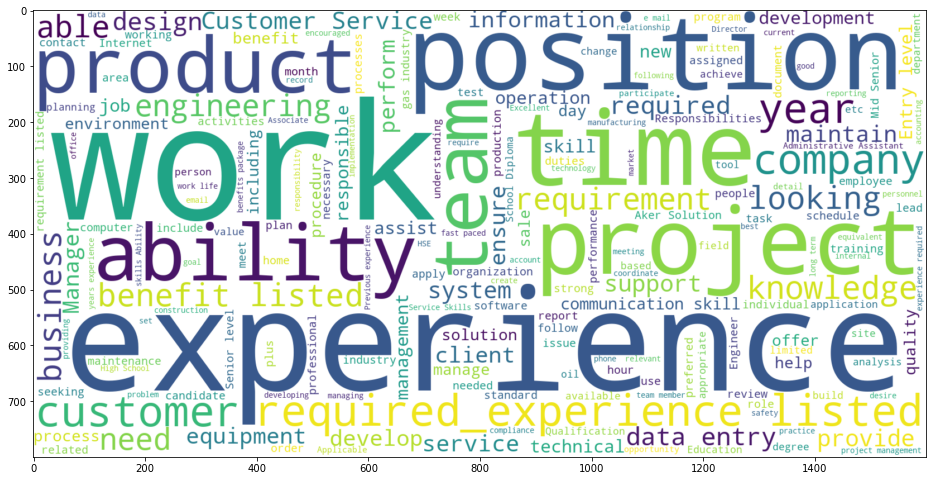

In [44]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               #max_words = 300, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

## Not Fraudulent Words! lol ✓

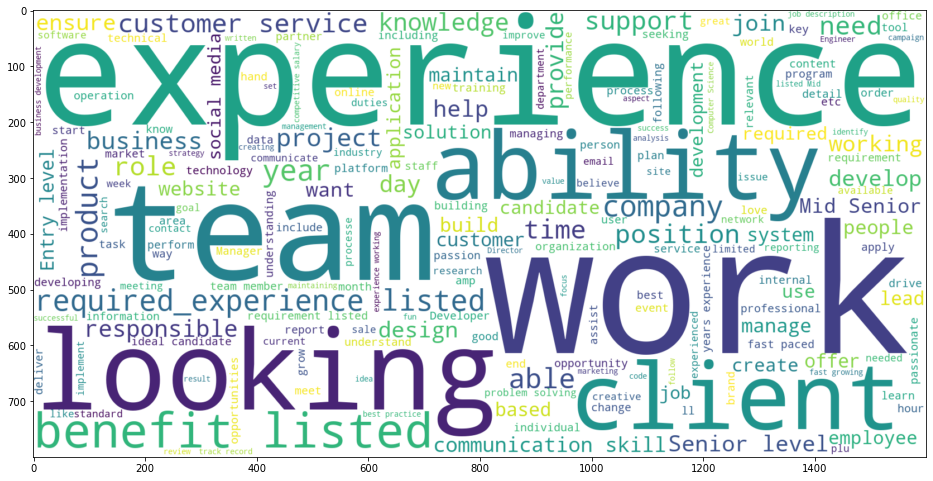

In [45]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               #max_words = 300, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

## Data Cleaning

In [46]:
#!python -m spacy download en_core_web_sm

In [47]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [84]:
data.text.isna().sum()

0

# Modelling

Trying with Spacy

In [49]:
# import string
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lang.en import English

In [50]:
# Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/


In [51]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [52]:
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
type(df.text[1])

str

In [85]:
mytest = parser(data.text[1])
mytest

  Marketing Intern  Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff  Experience with content management systems a major plus (any blogging cou

In [55]:
 #[ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytest ]

In [56]:

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [81]:
spacy_tokenizer(data.text[1])

[]

#### Trying with nltk

In [58]:
#from nltk.tokenize import word_tokenize

In [59]:
# import nltk
# nltk.download('punkt')
  

In [62]:
#from sklearn.base import TransformerMixin

In [63]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [64]:
#from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


In [65]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3))


In [66]:
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7f7bd12fc820>)

In [86]:
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [67]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.3)

In [68]:
X_train

job_id
1797       Operations Manager  Wikispaces is looking fo...
4793       Key Account Manager  Incrediblue is changing...
15106      Technical Support Engineer  Cloud 66 is a Te...
6379       Product Designer  Here at Shyp, we’re buildi...
15921      Senior Systems Administrator   About Worldst...
                               ...                        
8061       Military Veterans Wanted for Solar Energy Co...
1450       Support Genius  As a Support Genius you are ...
3327       Customer Assistant  Job Description: We are ...
1334       Continuous Improvement Lead  Our customer is...
2814       Basingstoke Fragrance/Beauty Staff Needed  W...
Name: text, Length: 12516, dtype: object

In [69]:
# from imblearn.over_sampling import SMOTE
# from  sklearn.pipeline import Pipeline

In [70]:
#!python -m spacy download en_core_web_sm

In [71]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7bb35b41c0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7bd12fc820>)),
                ('classifier', LogisticRegression())])

In [72]:
#from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

In [73]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9821029082774049
Logistic Regression Recall: 0.6313559322033898


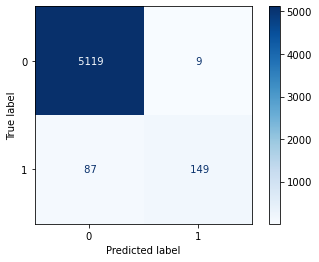

In [74]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

## Oh boy XD XD XD

1. Random Forest

In [75]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7b845e5100>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7bd12fc820>)),
                ('classifier', RandomForestClassifier())])

In [76]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9832214765100671
Random Forest Recall: 0.6313559322033898


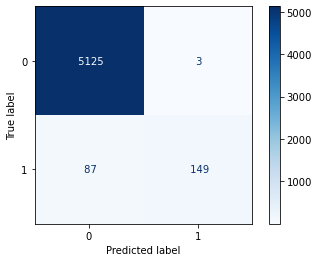

In [77]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

XGBoost Classifier

In [78]:
clf = XGBClassifier(random_state=42)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
#                  ("sampling", SMOTE(random_state=42))
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7b54c92100>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7bd12fc820>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
           

In [79]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9809843400447428
XGBoost Recall: 0.6016949152542372


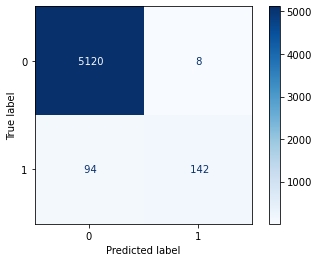

In [80]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')